In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
SudokuImgPath = './data/sudoku1.jpg'
img = cv2.imread(SudokuImgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def sudoku_part1(img):
    '''Integrated from Part 1.'''
    # Denoise.
    denoisedImg = cv2.medianBlur(img, 5)
    # Threashold.
    threshedImg = cv2.adaptiveThreshold(denoisedImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    threshedImg = cv2.medianBlur(threshedImg, 7)
    # Find contour.
    contours, _ = cv2.findContours(threshedImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))[::-1]
    puzzleContour = contours[0]
    # Find corners.
    perimeterContour = cv2.arcLength(puzzleContour, True)
    for i in range(0, 100):
        corners = cv2.approxPolyDP(puzzleContour, i / 100.0 * perimeterContour, True)
        if len(corners) == 4:
            break
    corners = np.array(corners).squeeze()
    # Get corners mapping.
    edgeLengths = [cv2.arcLength(np.array([corners[i], corners[j]]), False) for (i, j) in [(0, 1), (1, 2), (2, 3), (3, 1)]]
    height = width = int(max(edgeLengths))
    deskewedPoints = [(0, 0), (width - 1, 0), (width - 1, height - 1), (0, height - 1)] # Anti-clockwise.
    deskewedPoints = np.array(deskewedPoints)
    def getSkewedPoints(corners):
        '''Anti-clockwise.'''
        sum_ = corners.sum(axis=1)
        diff = -np.diff(corners, axis=1)
        br = corners[np.argmax(sum_)]
        tl = corners[np.argmin(sum_)]
        bl = corners[np.argmin(diff)]
        tr = corners[np.argmax(diff)]

        return np.array([tl, tr, br, bl])

    skewedPoints = getSkewedPoints(corners)
    # Deskew.
    transform = cv2.getPerspectiveTransform(skewedPoints.astype(np.float32), deskewedPoints.astype(np.float32))
    deskewedImg = cv2.warpPerspective(denoisedImg, transform, (width, height))

    return deskewedImg

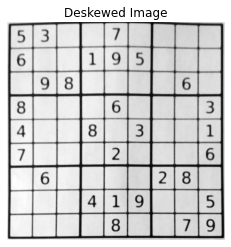

In [3]:
deskewedImg = sudoku_part1(img)

plt.figure()
plt.imshow(deskewedImg, cmap='gray'); plt.title('Deskewed Image'); plt.axis('off')
plt.show()

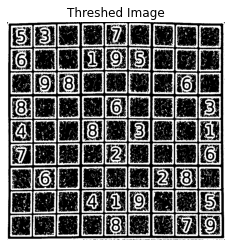

In [4]:
threshedImg = cv2.adaptiveThreshold(deskewedImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
plt.figure()
plt.imshow(threshedImg, cmap='gray'); plt.title('Threshed Image'); plt.axis('off')
plt.show()

In [5]:
def getSeedPoint(img, th=0.9):
    h, w = img.shape
    r = None
    for i in range(h):
        r = h - i - 1
        if np.sum(img[r, :]) <= (1.0 - th) * w * 255:
            break
    for c in range(w):
        if img[r, c] == 0:
            return c, r
    return None, None

SeedPoint = getSeedPoint(threshedImg)
SeedPoint

(3, 713)

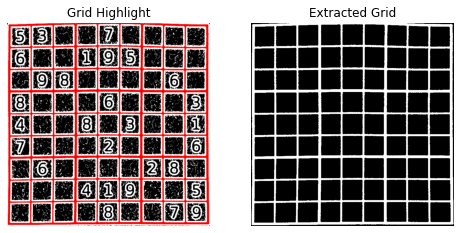

In [6]:
h, w = threshedImg.shape
gridImg = cv2.cvtColor(threshedImg, cv2.COLOR_GRAY2BGR)
gridMask = np.zeros((h + 2, w + 2), dtype=np.uint8)
_, gridMarkedImg, gridMask, _ = cv2.floodFill(gridImg, gridMask, SeedPoint, (255, 0, 0))
gridMask = gridMask[1:-1, 1:-1]
gridMask = cv2.dilate(gridMask, np.ones((3, 3)))
plt.figure(figsize=(8, 6))
plt.subplot(121); plt.imshow(gridMarkedImg, cmap='gray'); plt.title('Grid Highlight'); plt.axis('off')
plt.subplot(122); plt.imshow(gridMask, cmap='gray'); plt.title('Extracted Grid'); plt.axis('off')
plt.show()

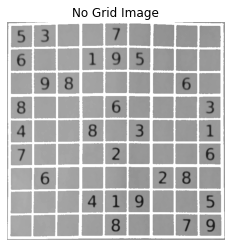

In [7]:
noGridImg = deskewedImg.copy()
noGridImg[gridMask != 0] = 255
plt.figure()
plt.imshow(noGridImg, cmap='gray', vmin=0, vmax=255); plt.title('No Grid Image'); plt.axis('off')
plt.show()

In [8]:
h, w = noGridImg.shape
cellH, cellW = h // 9, w // 9
centerCropH, centerCropW = 64, 64

def cropCell(img, row, col, cellH, cellW, centerCropH, centerCropW):
    assert row < 9 and col < 9 and row >= 0 and col >= 0
    
    r0 = row * cellH; c0 = col * cellW
    cell = np.array(img[r0 : r0 + cellH, c0 : c0 + cellW])
    leftTopRow = (cellH - centerCropH) // 2
    leftTopCol = (cellW - centerCropW) // 2
    cell = cell[leftTopRow : leftTopRow + centerCropH, leftTopCol : leftTopCol + centerCropW]
    
    return cell

cellImgs = []
for r in range(9):
    for c in range(9):
        cellImgs.append(cropCell(noGridImg, r, c, cellH, cellW, centerCropH, centerCropW))
    
cellImgs = np.array(cellImgs).reshape(9, 9, centerCropH, centerCropW)
cellImgs.shape

(9, 9, 64, 64)

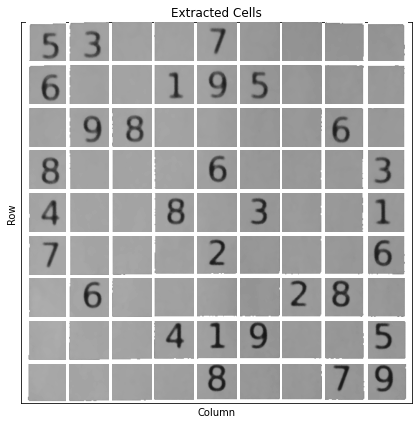

In [9]:
# see https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
fig = plt.figure(figsize=(7, 7))
plt.title('Extracted Cells'); plt.xlabel('Column'); plt.ylabel('Row'); plt.xticks([]); plt.yticks([])
grid = ImageGrid(fig, 111, nrows_ncols=(9, 9), axes_pad=0.05)

for ax, im in zip(grid, cellImgs.reshape(-1, centerCropH, centerCropW)):
    ax.imshow(im, cmap='gray', vmin=0, vmax=255); ax.axis('off')

plt.show()

In [10]:
nonZeros = []
threshedCells = []
for r in range(9):
    for c in range(9):
        cell = np.array(cellImgs[r, c, ...])
        cell[cell > (255 // 2)] = 255
        cell = cv2.adaptiveThreshold(cell, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 0)
        threshedCells.append(cell)
        nonZeros.append(cv2.countNonZero(cell))

threshedCells = np.array(threshedCells).reshape(9, 9, centerCropH, centerCropW)
nonZeros = np.array(nonZeros).reshape(9, 9)

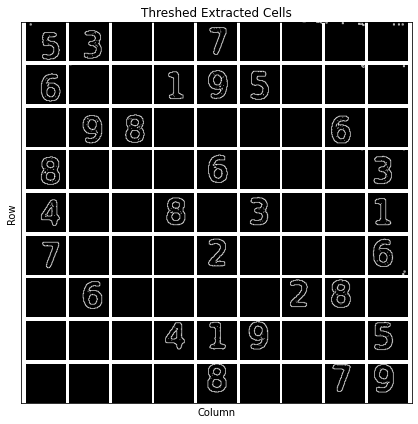

In [11]:
fig = plt.figure(figsize=(7, 7))
plt.title('Threshed Extracted Cells'); plt.xlabel('Column'); plt.ylabel('Row'); plt.xticks([]); plt.yticks([])
grid = ImageGrid(fig, 111, nrows_ncols=(9, 9), axes_pad=0.05)

for ax, im in zip(grid, threshedCells.reshape(-1, centerCropH, centerCropW)):
    ax.imshow(im, cmap='gray'); ax.axis('off')

plt.show()

In [12]:
nonZeros

array([[224, 222,   0,   0, 165,   0,  28,  42,  24],
       [253,   5,   0, 148, 262, 223,   0,  16,   8],
       [  0, 259, 277,   0,   0,   0,   0, 255,   0],
       [271,   0,   0,   0, 255,   0,   0,   5, 230],
       [200,   0,   0, 263,   0, 223,   0,   0, 153],
       [156,   0,   0,   0, 215,   0,   0,   0, 269],
       [  0, 247,   0,   0,   0,   0, 209, 269,   0],
       [  0,   0,   0, 202, 167, 259,   0,   0, 229],
       [  0,   0,   0,   0, 262,   0,   0, 170, 253]])

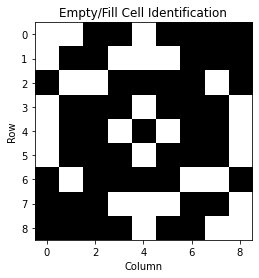

In [13]:
emptyFills = nonZeros.copy()
emptyFills[emptyFills < 125] = 0
emptyFills[emptyFills > 0] = 1
plt.figure()
plt.imshow(emptyFills, cmap='gray'); plt.title('Empty/Fill Cell Identification'); plt.xlabel('Column'); plt.ylabel('Row')
plt.show()